In the most recent release of GridDB CE (version 5.3), a new SQL function was added that allows a user to fetch interpolated or aggregated data for a set of time ranges over a total duration from a `TIMESERIES` container. We explored similar functionality before in this blog post [GridDB Optimization with Multi-Put and Query](https://griddb.net/en/blog/griddb-optimization-with-multi-put-and-query/) by building a set of queries to query each individual group and then efficiently executing them with GridDB’s multi-query function.

The new query function is quite simple:

`SELECT * FROM table WHERE ts_col > TIMESTAMP(start) and ts_col <= TIMESTAMP(end) GROUP BY RANGE (n, duration)`

In the above example, `ts_col` is is the index of the time-series container. The `start` and `end` variables are the starting and ending timestamps of the data queried and the query must have those clauses. Finally, each group’s duration is n*duration. The duration can be:

    DAY
    HOUR
    MINUTE
    SECOND
    MILLISECOND

You can also query an aggregate of each time group such as the MIN, MAX, AVG, COUNT, SUM, etc.

`SELECT ts_col,AVG(value) FROM table WHERE ts_col > TIMESTAMP(start) and ts_col <= TIMESTAMP(end) GROUP BY RANGE (n, duration)`

Finally, if your data is sparse, the non-aggregate query’s interpolation can be adjusted by appending `FILL(method)` to the end of the query. Available fill methods include:

    LINEAR
    NONE
    NULL
    PREVIOUS

## Hands On

Now, let’s get started trying it out. We’ll use the already ingested dataset from GridDB’s 101 Course [https://www.youtube.com/playlist?list=PLZiizI6Euect9q64akYBkiqLMS78UTwjO](https://www.udemy.com/course/create-a-working-iot-project-with-iot-database-griddb). Dataset can be found here on [Kaggle](https://www.kaggle.com/datasets/garystafford/environmental-sensor-data-132k). Code for ingestion can be found on the GitHub page (it's written in node.js.)

As this is a SQL function, it is only available via GridDB’s JDBC or WebAPI interface. In this blog we’ll be using the Python module `jpype.dbapi2` as it natively supports SQL and the Timestamp to Python datetime object conversion. Compare the following two outputs using `jaydebe` and `jpype.dbapi2`: jaydebe outputs a string while jype.dbapi2 outputs a datetime object. 

In [2]:
import jaydebeapi
                               
jdbeurl = "jdbc:gs://127.0.0.1:20001/myCluster/public"
jdbeconn = jaydebeapi.connect("com.toshiba.mwcloud.gs.sql.Driver", jdbeurl, ["admin", "admin"], "./gridstore-jdbc.jar")

jdbecurs = jdbeconn.cursor()
jdbecurs.execute("SELECT ts FROM device2 limit 1")
rows = jdbecurs.fetchall()
print(type(rows[0][0]), rows[0][0])

<class 'str'> 2020-07-11 17:01:34.735000


In [3]:
import jpype
import jpype.dbapi2
    
url = "jdbc:gs://127.0.0.1:20001/myCluster/public"
conn = jpype.dbapi2.connect(url, driver="com.toshiba.mwcloud.gs.sql.Driver", driver_args={"user": "admin", "password": "admin"})

curs = conn.cursor()
curs.execute("SELECT ts FROM device2 limit 1")
rows = curs.fetchall()
print(type(rows[0][0]), rows[0][0])

<class 'datetime.datetime'> 2020-07-11 17:01:34.735000


With the connection setup we can create a function that gets the first and last timestamps and build the group by range query. The function itself returns data as Pandas DataFrame with the columns set to match the table columns.

In [4]:
import datetime
import pandas as pd

def getRange(conn, table, range):
    curs = conn.cursor()
    curs.execute("SELECT min(ts),max(ts) from "+table)
    rows = curs.fetchall()
    start = rows[0][0];
    end = rows[0][1]

    curs.execute("""select * from """+table+""" where ts >= TO_TIMESTAMP_MS("""+str(int(start.timestamp()*1000))+""") 
                 and ts <= TO_TIMESTAMP_MS("""+str(int(end.timestamp()*1000))+""") group by range (ts) EVERY (1, """+range+""");""");

    cols = tuple(zip(*curs.description))[0]
    df = pd.DataFrame(curs.fetchall(), columns=cols)
    return df

def getAll(conn, table):
    curs = conn.cursor()

    curs.execute("""select * from """+table);

    cols = tuple(zip(*curs.description))[0]
    df = pd.DataFrame(curs.fetchall(), columns=cols)
    return df 

getRange(conn, "device2", "DAY")

,ts,co,humidity,light,lpg,motion,smoke,temp
0,2020-07-11 17:00:00,0.002840,76.000000,False,0.005114,False,0.013275,19.700001
1,2020-07-12 17:00:00,0.011738,73.900002,False,0.014276,False,0.039740,18.900000
2,2020-07-13 17:00:00,0.004167,74.300003,False,0.006749,False,0.017851,19.000000
3,2020-07-14 17:00:00,0.004577,73.699997,False,0.007222,False,0.019193,18.900000
4,2020-07-15 17:00:00,0.008437,73.599998,False,0.011243,False,0.030792,18.700001
5,2020-07-16 17:00:00,0.002350,74.800003,False,0.004459,False,0.011467,19.700001
6,2020-07-17 17:00:00,0.004816,76.500000,False,0.007494,False,0.019964,18.900000
7,2020-07-18 17:00:00,0.004878,77.099998,False,0.007563,False,0.020162,19.200001
8,2020-07-19 17:00:00,0.003700,75.599998,False,0.006193,False,0.016285,19.299999


Now let’s try an aggregate query:

In [5]:
def getAggregates(conn, table, agg, column, range):
    curs = conn.cursor()
    curs.execute("SELECT min(ts),max(ts) from "+table)
    rows = curs.fetchall()
    start = rows[0][0];
    end=rows[0][1]

    curs.execute("""select ts,"""+agg+"("+column+") from "+table+" where ts >= TO_TIMESTAMP_MS("+str(int(start.timestamp()*1000))+""") 
                 and ts <= TO_TIMESTAMP_MS("""+str(int(end.timestamp()*1000))+") group by range (ts) EVERY (1, "+range+");");

    df = pd.DataFrame(curs.fetchall(), columns=("ts", column))
    return df

getAggregates(conn, "device2", "min", "humidity", "DAY")

,ts,humidity
0,2020-07-11 17:00:00,21.600000
1,2020-07-12 17:00:00,22.900000
2,2020-07-13 17:00:00,22.100000
3,2020-07-14 17:00:00,22.100000
4,2020-07-15 17:00:00,21.400000
5,2020-07-16 17:00:00,23.799999
6,2020-07-17 17:00:00,24.299999
7,2020-07-18 17:00:00,1.100000
8,2020-07-19 17:00:00,75.300003


If you have a boolean column that represents an event and want to see that happened in each time grouping, you can use the MAX aggregation:

In [6]:
getAggregates(conn, "device2", "max", "motion", "DAY")

,ts,motion
0,2020-07-11 17:00:00,False
1,2020-07-12 17:00:00,False
2,2020-07-13 17:00:00,False
3,2020-07-14 17:00:00,False
4,2020-07-15 17:00:00,True
5,2020-07-16 17:00:00,False
6,2020-07-17 17:00:00,False
7,2020-07-18 17:00:00,True
8,2020-07-19 17:00:00,False


To count the number of events (or the number times a column is TRUE) in each time window, you need to add an additional clause AND column to your query:

In [7]:
def getBoolCount(conn, table, column, range):
    curs = conn.cursor()
    curs.execute("SELECT min(ts),max(ts) from "+table)
    rows = curs.fetchall()
    start = rows[0][0];
    end=rows[0][1]

    curs.execute("select ts,count("+column+") from "+table+" where ts >= TO_TIMESTAMP_MS("+str(int(start.timestamp()*1000))+""")
                  and ts <= TO_TIMESTAMP_MS("""+str(int(end.timestamp()*1000))+") and "+column+" group by range (ts) EVERY (1, "+range+");");

    df = pd.DataFrame(curs.fetchall(), columns=("ts", column))
    return df
    
getBoolCount(conn, "device2", "motion", "DAY")

,ts,motion
0,2020-07-11 17:00:00,NaN
1,2020-07-12 17:00:00,NaN
2,2020-07-13 17:00:00,NaN
3,2020-07-14 17:00:00,NaN
4,2020-07-15 17:00:00,2.0
5,2020-07-16 17:00:00,NaN
6,2020-07-17 17:00:00,NaN
7,2020-07-18 17:00:00,1.0
8,2020-07-19 17:00:00,NaN


Now that we know how to use the group by range aggregate function, we can build some diagrams that show useful statistics such as a bar chart showing the min and max values of each time group.

First since group by range is typically used to down sample data, lets compare every data point stored versus a daily interpolation:

In [8]:
getAll(conn, "device2")

,ts,co,humidity,light,lpg,motion,smoke,temp
0,2020-07-11 17:01:34.735,0.002840,76.000000,False,0.005114,False,0.013275,19.700001
1,2020-07-11 17:01:46.869,0.002938,76.000000,False,0.005241,False,0.013628,19.700001
2,2020-07-11 17:02:02.785,0.002905,75.800003,False,0.005199,False,0.013509,19.700001
3,2020-07-11 17:02:11.476,0.002938,75.800003,False,0.005241,False,0.013628,19.700001
4,2020-07-11 17:02:15.289,0.002840,76.000000,False,0.005114,False,0.013275,19.700001
...,...,...,...,...,...,...,...,...
111810,2020-07-19 17:03:16.329,0.003745,75.300003,False,0.006247,False,0.016437,19.200001
111811,2020-07-19 17:03:20.684,0.003745,75.400002,False,0.006247,False,0.016437,19.200001
111812,2020-07-19 17:03:25.039,0.003745,75.400002,False,0.006247,False,0.016437,19.200001
111813,2020-07-19 17:03:33.162,0.003745,75.300003,False,0.006247,False,0.016437,19.200001


Getting all rows (above) results in 111815 rows with each row approximately 5-30 seconds appart. Using group by range to down sample to hourly results in only 193 rows.

In [15]:
getRange(conn, "device2", "HOUR")

,ts,co,humidity,light,lpg,motion,smoke,temp
0,2020-07-11 17:00:00,0.002840,76.000000,False,0.005114,False,0.013275,19.700001
1,2020-07-11 18:00:00,0.002528,75.599998,False,0.004701,False,0.012133,19.600000
2,2020-07-11 19:00:00,0.002375,76.300003,False,0.004494,False,0.011562,19.700001
3,2020-07-11 20:00:00,0.002395,76.300003,False,0.004520,False,0.011635,19.700001
4,2020-07-11 21:00:00,0.002613,74.699997,False,0.004815,False,0.012445,19.500000
...,...,...,...,...,...,...,...,...
188,2020-07-19 13:00:00,0.002613,77.000000,False,0.004815,False,0.012445,19.600000
189,2020-07-19 14:00:00,0.003049,75.199997,False,0.005384,False,0.014023,19.600000
190,2020-07-19 15:00:00,0.003230,75.400002,False,0.005613,False,0.014662,19.200001
191,2020-07-19 16:00:00,0.003570,75.699997,False,0.006034,False,0.015840,19.299999


Now lets plot the same two data sets:

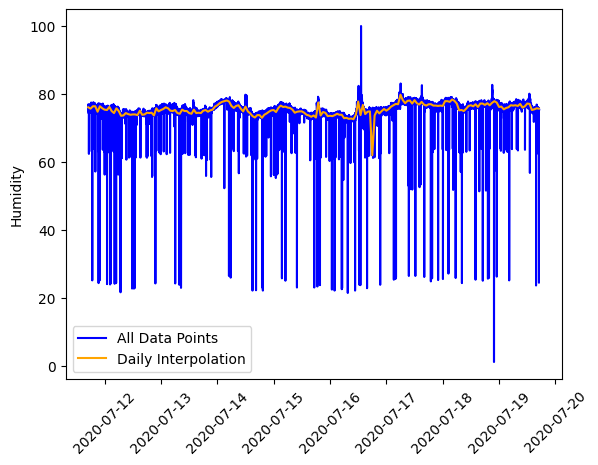

In [16]:
import matplotlib.pyplot as plt

day = getRange(conn, "device2", "HOUR")
all = getAll(conn, "device2")

plt.plot(all['ts'],  all['humidity'], label='All Data Points', color='blue')
plt.plot(day['ts'],  day['humidity'], label='Daily Interpolation', color='orange')
plt.xticks(rotation = 45);
plt.ylabel('Humidity')
plt.legend(loc="lower left");


Now we visualize daily minimums and maximums:

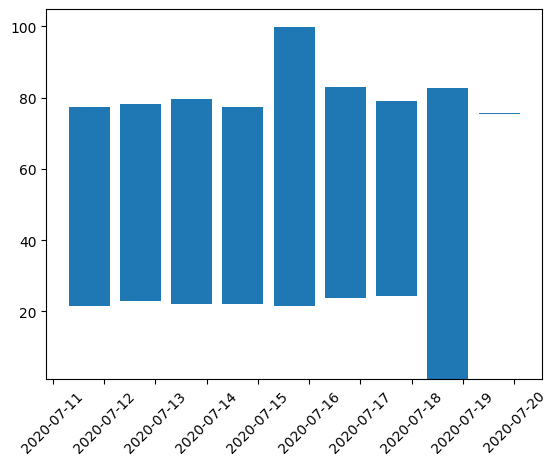

In [10]:
mins = getAggregates(conn, "device2", "min", "humidity", "DAY")
maxes = getAggregates(conn, "device2", "max", "humidity", "DAY")

plt.bar(mins['ts'], maxes["humidity"]-mins["humidity"], bottom=mins["humidity"]);
plt.xticks(rotation = 45);

We can expand on the above graph by adding data from the interpolated values too. Note how the interpolated value (red) is slightly different from the AVG aggregate (yellow).

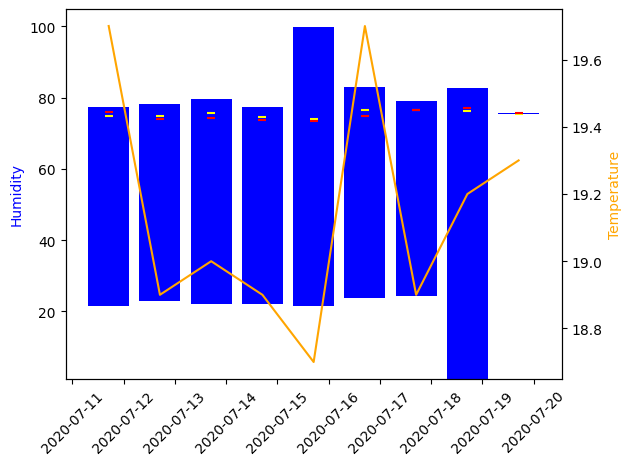

In [11]:
mins = getAggregates(conn, "device2", "min", "humidity", "DAY")
maxes = getAggregates(conn, "device2", "max", "humidity", "DAY")
avgs = getAggregates(conn, "device2", "avg", "humidity", "DAY")
all = getRange(conn, "device2", "DAY")

plt.bar(mins['ts'], maxes["humidity"]-mins["humidity"], bottom=mins["humidity"], color='blue')
plt.scatter(x=avgs['ts'], y=avgs['humidity'], color='yellow', marker='_')
plt.scatter(x=all['ts'], y=all['humidity'], color='red', marker='_')
plt.xticks(rotation = 45);
plt.ylabel('Humidity', color='blue')

plt2 = plt.twinx()
plt2.plot(all['ts'],  all['temp'], color='orange')
plt2.set_ylabel('Temperature', color='orange');

Finally, group by range can also interpolate values between data points with the FILL function. This is useful if data is sparse or at random intervals and you want to build a table. You can see the missing intervals without using fill and how FILL(PREVIOUS) continues to use the last value until a new value is met while FILL(LINEAR) interpolates the values between data points.

In [12]:
def getRangeFilled(conn, table, range, fill):
    curs = conn.cursor()
    curs.execute("SELECT min(ts),max(ts) from "+table)
    rows = curs.fetchall()
    start = rows[0][0];
    end = rows[0][1]

    curs.execute("""select * from """+table+""" where ts >= TO_TIMESTAMP_MS("""+str(int(start.timestamp()*1000))+""") 
                 and ts <= TO_TIMESTAMP_MS("""+str(int(end.timestamp()*1000))+""") group by range (ts) EVERY (1, """+range+""")
                 FILL("""+fill+""");""");

    cols = tuple(zip(*curs.description))[0]
    df = pd.DataFrame(curs.fetchall(), columns=cols)
    return df
    
prev = getRangeFilled(conn, "subdevice2", "MINUTE", "PREVIOUS").head(10)
nofill = getRange(conn, "subdevice2", "MINUTE").head(10)
linear = getRangeFilled(conn, "subdevice2", "MINUTE", "LINEAR").head(10)
all = getAll(conn, "subdevice2").head(10)

df = pd.DataFrame()
df.index = nofill.index
df['no_fill'] = nofill['humidity']
df['prev_fill'] = prev['humidity']
df['linear_fill'] = linear['humidity']
df

,no_fill,prev_fill,linear_fill
0,75.199997,75.199997,75.199997
1,NaN,75.199997,75.033330
2,NaN,75.199997,74.866664
3,74.699997,74.699997,74.699997
4,NaN,74.699997,74.765214
5,NaN,74.699997,74.830432
6,NaN,74.699997,74.895649
7,NaN,74.699997,74.960867
8,NaN,74.699997,75.026084
9,NaN,74.699997,75.091301


Visualizing the above data shows the concept even more clearly with the FILL(PREVIOUS) plot nearly matching the lines drawn by MatPlotLib between unfilled points:

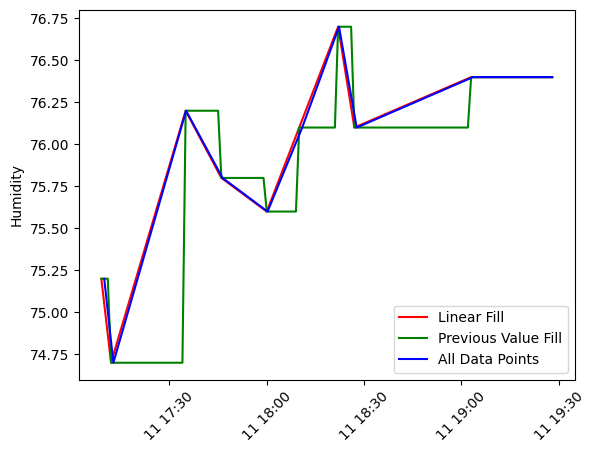

In [13]:
last = getRangeFilled(conn, "subdevice2", "MINUTE", "PREVIOUS").head(140)
filled = getRangeFilled(conn, "subdevice2", "MINUTE", "LINEAR").head(140)
all = getAll(conn, "subdevice2").head(10)

plt.plot(filled['ts'],  filled['humidity'], label='Linear Fill', color='red')
plt.plot(last['ts'],  last['humidity'], label='Previous Value Fill', color='green')
plt.plot(all['ts'],  all['humidity'], label='All Data Points', color='blue')

plt.xticks(rotation = 45);
plt.ylabel('Humidity')
plt.legend(loc="lower right");


If you’d like to experiment with the group by range function, the above Jupyter notebook can be downloaded from GridDB.net’s GitHub repository here [https://github.com/griddbnet/Blogs/blob/group_by_range/group_by_range.ipynb](https://github.com/griddbnet/Blogs/blob/group_by_range/group_by_range.ipynb).